# New Contestant
## VGG19

### Will challenge ResNet20

VGG19, introduced by the Visual Geometry Group (Simonyan & Zisserman, 2014), is a deep convolutional neural network known for its simple yet effective architecture. It consists of 19 layers, including 16 convolutional layers and 3 fully connected layers, utilizing small 3x3 filters with a stride of 1 and 2x2 max-pooling layers. The model's depth allows it to learn hierarchical feature representations, making it well-suited for image classification tasks. Despite its straightforward design, VGG19 has shown excellent performance in large-scale image recognition benchmarks, serving as a foundation for various computer vision tasks such as object recognition and transfer learning.


Reference: Simonyan, K., & Zisserman, A. (2014). Very Deep Convolutional Networks for Large-Scale Image Recognition. arXiv. https://arxiv.org/abs/1409.1556


In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

CIFAR-10 is a popular dataset used for training machine learning models, consisting of 60,000 32x32 color images in 10 different classes. In this section, we will load the CIFAR-10 dataset using TensorFlow and PyTorch. The dataset is split into 50,000 training images and 10,000 test images.

Same dataset was used for ResNet20.

In [ ]:
def data_loader(data_dir,
                    batch_size,
                    random_seed=42,
                    valid_size=0.1,
                    shuffle=True,
                    test=False):

        normalize = transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        )

        
        transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                normalize,
        ])
        download = not os.path.exists(os.path.join(data_dir, "cifar-10-batches-py"))
        print(download)
        if test:
            dataset = datasets.CIFAR10(
              root=data_dir, train=False,
              download=download, transform=transform,
            )

            data_loader = torch.utils.data.DataLoader(
                dataset, batch_size=batch_size, shuffle=shuffle
            )

            return data_loader

       
        train_dataset = datasets.CIFAR10(
            root=data_dir, train=True,
            download=download, transform=transform,
        )


        num_train = len(train_dataset)
        indices = list(range(num_train))
        split = int(np.floor(valid_size * num_train))

        if shuffle:
            np.random.seed(42)
            np.random.shuffle(indices)

        train_idx, valid_idx = indices[split:], indices[:split]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, sampler=train_sampler,num_workers=2,pin_memory=True)

        valid_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, sampler=valid_sampler)

        return (train_loader, valid_loader)
train_loader, valid_loader = data_loader(data_dir='/content/rn',
                                             batch_size=64)

test_loader = data_loader(data_dir='/content/rn',
                                  batch_size=64,
                                  test=True)

True


100%|██████████| 170M/170M [00:03<00:00, 49.2MB/s]


Extracting /content/rn/cifar-10-python.tar.gz to /content/rn
False


The VGG19 class defines a convolutional neural network architecture based on the VGG model, with 19 layers, including convolutional and fully connected layers. In the __init__ method, the model is initialized with a sequence of convolutional layers followed by ReLU activations, and a classifier consisting of three fully connected layers. The architecture is designed using the _make_layer_set method, which constructs the network's layers based on the specified number of channels and repetitions. The network uses Kaiming initialization for the convolutional layers and normal initialization for the fully connected layers. The forward method passes the input through the layers, applies a flattening step, and outputs the classification results.

In [6]:
class VGG19(nn.Module):
        def __init__(self, num_classes = 10):
            super(VGG19, self).__init__()
            self.in_channels = 3
            self.layer_set = self._make_layer_set([(64, 2), (128, 2), (256, 4),(512, 4),(512, 4)])
            self.classifier = nn.Sequential(
                nn.Linear(512*7*7, 4096), nn.ReLU(inplace=True),
                nn.Linear(4096, 4096), nn.ReLU(inplace=True),
                nn.Linear(4096, num_classes)
            )
            for m in self.modules():
              if isinstance(m, nn.Conv2d):
                  nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                  if m.bias is not None:
                      nn.init.constant_(m.bias, 0)
              elif isinstance(m, nn.Linear):
                  nn.init.normal_(m.weight, 0, 0.01)
                  nn.init.constant_(m.bias, 0)
        def _make_layer_set(self, arch):
            layers = []
            for n_c, n_l in arch:
                layers.append(
                    nn.Sequential(
                        nn.Conv2d(self.in_channels, n_c, kernel_size=3, padding=1),
                        nn.ReLU(inplace=True)
                    )
                )
                for i in range(n_l-1):
                    layers.append(
                        nn.Sequential(
                            nn.Conv2d(n_c, n_c, kernel_size=3, padding=1),
                            nn.ReLU(inplace=True)
                        )
                    )
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
                self.in_channels = n_c

            return nn.Sequential(*layers)

        def forward(self, x):
            x = self.layer_set(x)
            x = x.view(x.size(0), -1)
            x = self.classifier(x)

            return x

The VGG19 model, originally designed for the ImageNet dataset, employs a deep architecture with 19 layers, including 16 convolutional layers and 3 fully connected layers. For training on the CIFAR-10 dataset on our limited GPU resources adjustments to hyperparameters are necessary to optimize performance. Modifications include reducing the learning rate, decreasing the number of epochs.

We also use lr scheduler instead of manually adjusting lr(Practiced orginally).

Although we were able to use 128 batches in ResNet20, we were forced to use 64 batch size because of this architechtures huge size, causing Out of Memory erros.

This architecture is comparably huge becuase it uses 3 Fully connected layers, unlike ResNet which uses only 1.

In [ ]:
num_classes = 10
num_epochs = 10
batch_size = 64
learning_rate = 0.001

model = VGG19()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[5,8],
                                               gamma=0.1)

total_step = len(train_loader)

In [8]:
# from google.colab import drive
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
# drive.mount('/content/drive')

The training loop includes model checkpointing, which saves the model, optimizer, and scheduler states every two epochs to allow resuming training if interrupted. It also implements early stopping based on validation accuracy, halting training after three consecutive epochs of no improvement. Additionally, the loop ensures efficient memory management by clearing tensors and invoking garbage collection after each batch.

In [9]:
import gc
import time

checkpoint_path = "/content/vgg19_checkpoint3.pth"


start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    scheduler.load_state_dict(checkpoint["scheduler_state"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}")
total_step = len(train_loader)
best_val = -1
tolerance = 3
t = 0
for epoch in range(start_epoch, num_epochs):
    t = time.time()
    for i, (images, labels) in enumerate(train_loader):
        if total_step/2 == i+1:
          print("half way there")
        #Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    scheduler.step()
    if (epoch + 1) % 2 == 0:
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state":scheduler.state_dict()
        }, os.path.join(os.path.dirname(checkpoint_path), f"vgg19_checkpoint3_{epoch}.pth"))
        print(f"Checkpoint saved at epoch {epoch+1}")
    print ('epoch {}, loss: {:.4f}'.format(epoch+1, loss.item()))
    print("Time: ", time.time()-t)

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        print(f'Val acc: {val_acc:.2f}%')


    if epoch > 0 and val_acc <= best_val:
        tolerance -= 1
        if tolerance == 0:
            print("early stopping")
            break
    else:
        best_val = val_acc
        tolerance = 3

half way there
epoch 1, loss: 1.8316
Time:  862.3912055492401
Val acc: 42.32%
half way there
Checkpoint saved at epoch 2
epoch 2, loss: 1.0693
Time:  886.5451471805573
Val acc: 53.96%
half way there
epoch 3, loss: 1.0820
Time:  875.1750333309174
Val acc: 56.78%
half way there
Checkpoint saved at epoch 4
epoch 4, loss: 0.4137
Time:  891.848908662796
Val acc: 64.32%
half way there
epoch 5, loss: 0.8843
Time:  878.8813018798828
Val acc: 63.06%
half way there
Checkpoint saved at epoch 6
epoch 6, loss: 0.2467
Time:  933.470449924469
Val acc: 70.72%
half way there
epoch 7, loss: 0.4964
Time:  883.2415471076965
Val acc: 70.00%
half way there
Checkpoint saved at epoch 8
epoch 8, loss: 0.0377
Time:  909.1188766956329
Val acc: 69.54%
half way there
epoch 9, loss: 0.0376
Time:  881.9681146144867
Val acc: 69.96%
early stopping


Again since the architecture is very dense, it frequently encountered overfitting. After adding lower 'tolerance', This forced the algorithm to stop early at epoch 9.

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, class_labels):
      cm = confusion_matrix(y_true, y_pred)
      plt.figure(figsize=(8, 6))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
      plt.xlabel('Predicted Label')
      plt.ylabel('True Label')
      plt.show()


After testing the model at the last checkpoint (epoch 8, saved as 7 due to starting from 0), we achieved a solid 70% accuracy. 

We acheived 70% accuracy. This was great since the accuracy is comparable to our ResNet variant(66%), making it controlled environment for testing on quantization.

Now, we're taking it to the next level—quantizing this model and throwing it into a challenge against other ResNet20 models. Stay tuned to see who comes out on top!

<ipython-input-15-bee5a257cff8>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')


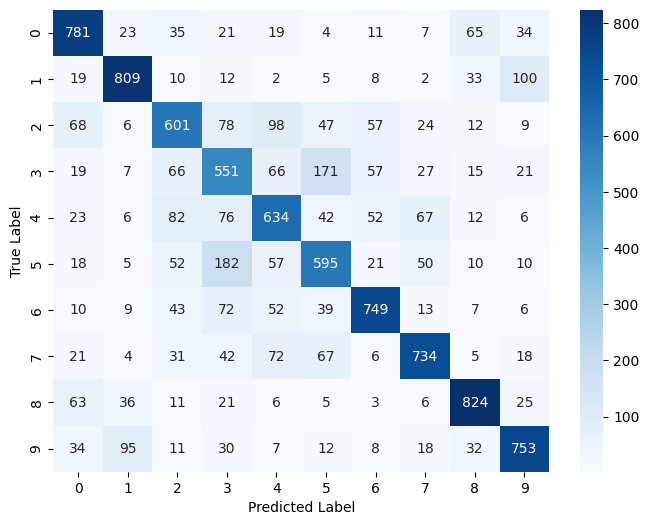

Accuracy 70.31%


In [15]:
y_pred = []
y_true = []
model.eval()
checkpoint_path = "/content/vgg19_checkpoint3_7.pth"

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    scheduler.load_state_dict(checkpoint["scheduler_state"])
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        model.to(device)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

plot_confusion_matrix(y_true, y_pred, range(0,10))
print('Accuracy {}%'.format(100 * correct / total))